In [1]:
# Modules we will use
import warnings
import numpy
from matplotlib import pyplot
import chaospy

warnings.filterwarnings("ignore", category=RuntimeWarning)

## Regression with Scikit-Learn

The library `scikit-learn` is a great machine-learning toolkit that provides a large collection of regression methods.
By default, `chaospy` only support traditional least-square regression, but is also designed to work together with the various regression functions provided by `scikit-learn`.

Because `scikit-learn` isn't a required dependency, you might need to install it first with e.g. `pip install scikit-learn`. When that is done, it should be importable:

In [2]:
import sklearn

As en example to follow, consider the following artificial case:

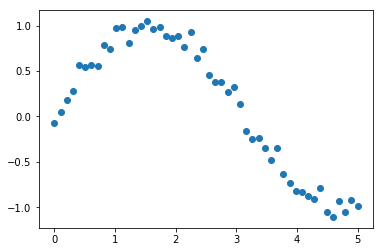

In [3]:
samples = numpy.linspace(0, 5, 50)
noise = chaospy.Normal(0, 0.1).sample(50)
evals = numpy.sin(samples) + noise

pyplot.scatter(samples, evals)
pyplot.show()

### Least squares regression

By default, `chaospy` does not use `sklearn` (and can be used without `sklearn` being installed). Instead it uses `scipy.linalg.lstsq`, which is the ordinary least squares method, the classical regression problem by minimizing the residulals squared.

In practice:

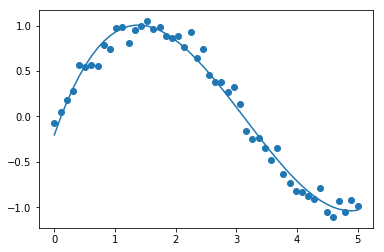

polynomial(0.0951*q0**3-0.8944*q0**2+1.9294*q0-0.2025)

In [4]:
q0 = chaospy.variable()
expansion = chaospy.polynomial([1, q0, q0**2, q0**3])

fitted_polynomial = chaospy.fit_regression(expansion, samples, evals)

pyplot.scatter(samples, evals)
pyplot.plot(samples, fitted_polynomial(samples))
pyplot.show()

fitted_polynomial.round(4)

Least squares regression is also supported by `sklearn`. So it is possible to get the same result using the `LinearRegression` model. For example:

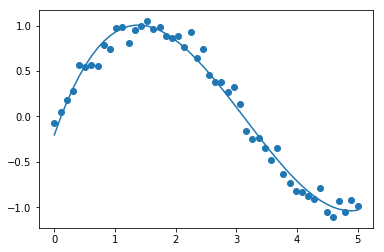

polynomial(0.0951*q0**3-0.8944*q0**2+1.9294*q0-0.2025)

In [5]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False)
fitted_polynomial = chaospy.fit_regression(expansion, samples, evals, model=model)

pyplot.scatter(samples, evals)
pyplot.plot(samples, fitted_polynomial(samples))
pyplot.show()

fitted_polynomial.round(4)

It is important to note that sklearn often does extra operations that may interfer with the compatability of `chaospy`. Here `fit_intercept=False` ensures that an extra columns isn't added needlessly. An error will be raised if this is forgotton.

### Single Variable Regression Methods

While in most cases least squares regression is sufficient, that is not always the case. For those deviating cases `scikit-learn` provides a set of alternative methods. Even though `chaospy` doesn't differentiate between single dimensional and multi-dimensional responses, `scikit-learn` do.

The methods that support single dimensional responses are:

* `least squares` -- Simple $L_2$ regression without any extra features.
* `elastic net` -- $L_2$ regression with both $L_1$ and $L_2$ regularization terms.
* `lasso` -- $L_2$ regression with an extra $L_1$ regularization term, and a preference for fewer non-zero terms.
* `lasso lars` -- An implementation of `lasso` meant for high dimensional data.
* `orthogonal matching pursuit` -- $L_2$ regression with enforced number of non-zero terms.
* `ridge` -- $L_2$ regression with an $L_2$ regularization term.
* `bayesian ridge` -- Same as `ridge`, but uses Bayesian probability to let data estimate the complexity parameter.
* `auto relevant determination` -- Same as `bayesian ridge`, but also favors fewer non-zero terms.

In [6]:
from sklearn import linear_model

univariate_models = {
    "least squares": linear_model.LinearRegression(fit_intercept=False),
    "elastic net": linear_model.ElasticNet(alpha=0.1, fit_intercept=False),
    "lasso": linear_model.Lasso(alpha=0.1, fit_intercept=False),
    "lasso lars": linear_model.LassoLars(alpha=0.1, fit_intercept=False),
    "orthogonal matching pursuit": linear_model.OrthogonalMatchingPursuit(
        n_nonzero_coefs=3, fit_intercept=False),
    "ridge": linear_model.Ridge(alpha=0.1, fit_intercept=False),
    "bayesian ridge": linear_model.BayesianRidge(fit_intercept=False),
    "auto relevant determination": linear_model.ARDRegression(fit_intercept=False),
}

Again, as the polynomials already addresses the constant term, it is important to remember to include `fit_intercept=False` for each model.

We can then create a fit for each of the univariate models:

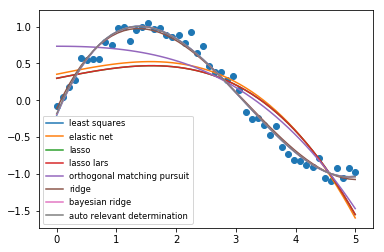

In [7]:
for label, model in univariate_models.items():
    fitted_polynomial = chaospy.fit_regression(expansion, samples, evals, model=model)
    pyplot.plot(samples, fitted_polynomial(samples), label=label)

pyplot.scatter(samples, evals)
pyplot.legend(loc="lower left")
pyplot.show()

### Multi-variable Regression Methods

This part of the tutorial uses the same example as the [example introduction](./example_introduction.ipynb).
In other words:

In [8]:
from chaospy.example import coordinates, exponential_model, distribution, error_mean, error_variance

The methods that support multi-label dimensional responses are:

* `least squares` -- Simple $L_2$ regression without any extra features.
* `elastic net` -- $L_2$ regression with both $L_1$ and $L_2$ regularization terms.
* `lasso` -- $L_2$ regression with an extra $L_1$ regularization term, and a preference for fewer non-zero terms.
* `lasso lars` -- An implementation of `lasso` meant for high dimensional data.
* `orthogonal matching pursuit` -- $L_2$ regression with enforced number of non-zero terms.
* `ridge` -- $L_2$ regression with an $L_2$ regularization term.

In [9]:
multivariate_models = {
    "least squares": linear_model.LinearRegression(fit_intercept=False),
    "elastic net": linear_model.MultiTaskElasticNet(alpha=0.2, fit_intercept=False),
    "lasso": linear_model.MultiTaskLasso(alpha=0.2, fit_intercept=False),
    "lasso lars": linear_model.LassoLars(alpha=0.2, fit_intercept=False),
    "orthogonal matching pursuit": linear_model.OrthogonalMatchingPursuit(
        n_nonzero_coefs=3, fit_intercept=False),
    "ridge": linear_model.Ridge(alpha=0.2, fit_intercept=False),
}

To illustrate the difference between the methods, we do the simple error analysis:

In [10]:
expansion = chaospy.orth_ttr(2, distribution)
samples = distribution.sample(50)
evals = numpy.array([exponential_model(sample) for sample in samples.T])

for label, model in multivariate_models.items():
    
    fitted_polynomial, coeffs = chaospy.fit_regression(expansion, samples, evals, model=model, retall=True)
    self_evals = fitted_polynomial(*samples)
    error_mean_ = error_mean(chaospy.E(fitted_polynomial, distribution))
    error_var_ = error_variance(chaospy.Var(fitted_polynomial, distribution))
    count_non_zero = numpy.sum(numpy.any(coeffs, axis=-1))
    
    print(f"{label:<30} {error_mean_:.5f} {error_var_:.5f} {count_non_zero}")

least squares                  0.00036 0.00001 6
elastic net                    0.06685 0.02052 2
lasso                          0.00199 0.01612 2
lasso lars                     0.19022 0.02121 1
orthogonal matching pursuit    0.00044 0.00112 3
ridge                          0.00160 0.01186 6


It is worth noting that as some of the method removes coefficients, it can function at higher polynomial order than the saturate methods.